In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import skimage.morphology

# Define the function to compute the boundaries based on a mathematical morphology
def computeBoundaries(signal, th):
    locs = np.where(signal > th)[0]
    indexes = np.zeros((signal.shape[0], 1))
    indexes[locs] = 1

    # Morphological operations
    selem = np.ones((70, 1))
    closed = skimage.morphology.closing(indexes, selem)
    opened = skimage.morphology.opening(closed, selem)

    locsNew = np.where(opened == 1)[0]
    derNew = np.diff(locsNew)
    ind = np.where(derNew > 1)[0]

    ending = np.append(locsNew[ind], locsNew[-1])
    starting = np.append(locsNew[0], locsNew[ind + 1])

    return starting, ending

def plot_and_segment_cube_signals(cube_number, threshold):
    cube_name = f'Cube{cube_number}'
    cube_path = os.path.join(base_path, cube_name)

    global segmented_data_dict  # Use the global dictionary to store results

    sampling_rate = 200000  # 200,000 Hz
    time_step = 1 / sampling_rate  # Time step in seconds

    # 10 conditions, with 2 subplots (for channels 0 and 1) per condition
    fig, axes = plt.subplots(10, 2, figsize=(12, 40))
    fig.suptitle(f'{cube_name} Signals with Segment Markers', fontsize=16)

    for i in range(10):  # For each condition
        # Load channel data
        data_channel_0 = pd.read_csv(os.path.join(cube_path, 'channel_0', f'File_{i}.csv')).to_numpy().flatten()
        data_channel_1 = pd.read_csv(os.path.join(cube_path, 'channel_1', f'File_{i}.csv')).to_numpy().flatten()

        # Calculate time array for plotting
        time_array = np.arange(data_channel_0.size) * time_step

        # Use channel 1 to find boundaries
        starting_1, ending_1 = computeBoundaries(data_channel_1, threshold)
        num_segments = len(starting_1)
        segment_sizes = ending_1 - starting_1
        avg_size = np.mean(segment_sizes)
        std_dev = np.std(segment_sizes)

        # Print the statistics for the segments
        print(f'Condition {i+1}: Found {num_segments} segments, Avg. Size: {avg_size:.2f}, Std. Dev: {std_dev:.2f}')

        # Plot signals with markers
        for j, (channel_data, time) in enumerate([(data_channel_0, time_array), (data_channel_1, time_array)]):
            ax = axes[i, j]
            ax.plot(time, channel_data)
            param_set = params_dict[cube_name][i]
            title = f'Cond {i+1}: {param_set["Power (W)"]}W, {param_set["Speed (mm/s)"]}mm/s'
            ax.set_title(title)
            ax.set_xlabel('Time (s)')
            ax.set_ylabel(f'Signal - channel_{j}')
            # Add markers for the start and end of each segment
            for start in starting_1:
                ax.axvline(x=time_array[start], color='green', linestyle='--')
            for end in ending_1:
                ax.axvline(x=time_array[end], color='red', linestyle='--')

        # Segment both channels using the computed boundaries and organize the data into a tensor
        min_size = min(segment_sizes)
        data_tensor = np.zeros((num_segments, 2, min_size))
        for seg_index, start in enumerate(starting_1):
            end = start + min_size
            data_tensor[seg_index, 0, :] = data_channel_0[start:end]
            data_tensor[seg_index, 1, :] = data_channel_1[start:end]

        # Store in the dictionary with parameters as keys
        key = (param_set['Power (W)'], param_set['Speed (mm/s)'], cube_number)
        segmented_data_dict[key] = data_tensor

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [2]:
# Path to data
base_path = './Data/Neuchatel_Ti64/'


In [3]:
# Load parameters from Excel into a dictionary
excel_path = './experiment_parameters.xlsx'
xl = pd.ExcelFile(excel_path)
params_dict = {}
for sheet_name in xl.sheet_names:
    df = xl.parse(sheet_name)
    params_dict[sheet_name] = df[['Speed (mm/s)', 'Power (W)', 'Power perc (%)']].to_dict('records')

params_dict

{'Cube1': [{'Speed (mm/s)': 1050, 'Power (W)': 90, 'Power perc (%)': 18},
  {'Speed (mm/s)': 800, 'Power (W)': 90, 'Power perc (%)': 18},
  {'Speed (mm/s)': 1800, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 1300, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 550, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 800, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 1300, 'Power (W)': 90, 'Power perc (%)': 18},
  {'Speed (mm/s)': 1050, 'Power (W)': 105, 'Power perc (%)': 21},
  {'Speed (mm/s)': 1550, 'Power (W)': 90, 'Power perc (%)': 18},
  {'Speed (mm/s)': 1800, 'Power (W)': 105, 'Power perc (%)': 21}],
 'Cube2': [{'Speed (mm/s)': 800, 'Power (W)': 105, 'Power perc (%)': 21},
  {'Speed (mm/s)': 300, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 1300, 'Power (W)': 105, 'Power perc (%)': 21},
  {'Speed (mm/s)': 1050, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 300, 'Power (W)': 105, 'Power perc (%)': 21},
 

In [4]:
# Initialize the dictionary to hold the segmented data tensors
segmented_data_dict = {}


Working on cube 1
Condition 1: Found 7 segments, Avg. Size: 2330.71, Std. Dev: 59.98
Condition 2: Found 8 segments, Avg. Size: 3518.62, Std. Dev: 747.49
Condition 3: Found 10 segments, Avg. Size: 1471.00, Std. Dev: 176.31
Condition 4: Found 6 segments, Avg. Size: 2005.33, Std. Dev: 79.02
Condition 5: Found 10 segments, Avg. Size: 3947.00, Std. Dev: 112.14
Condition 6: Found 10 segments, Avg. Size: 2846.50, Std. Dev: 186.12
Condition 7: Found 10 segments, Avg. Size: 1753.00, Std. Dev: 91.77
Condition 8: Found 10 segments, Avg. Size: 2076.60, Std. Dev: 96.59
Condition 9: Found 10 segments, Avg. Size: 1525.10, Std. Dev: 109.46
Condition 10: Found 10 segments, Avg. Size: 1233.20, Std. Dev: 68.13


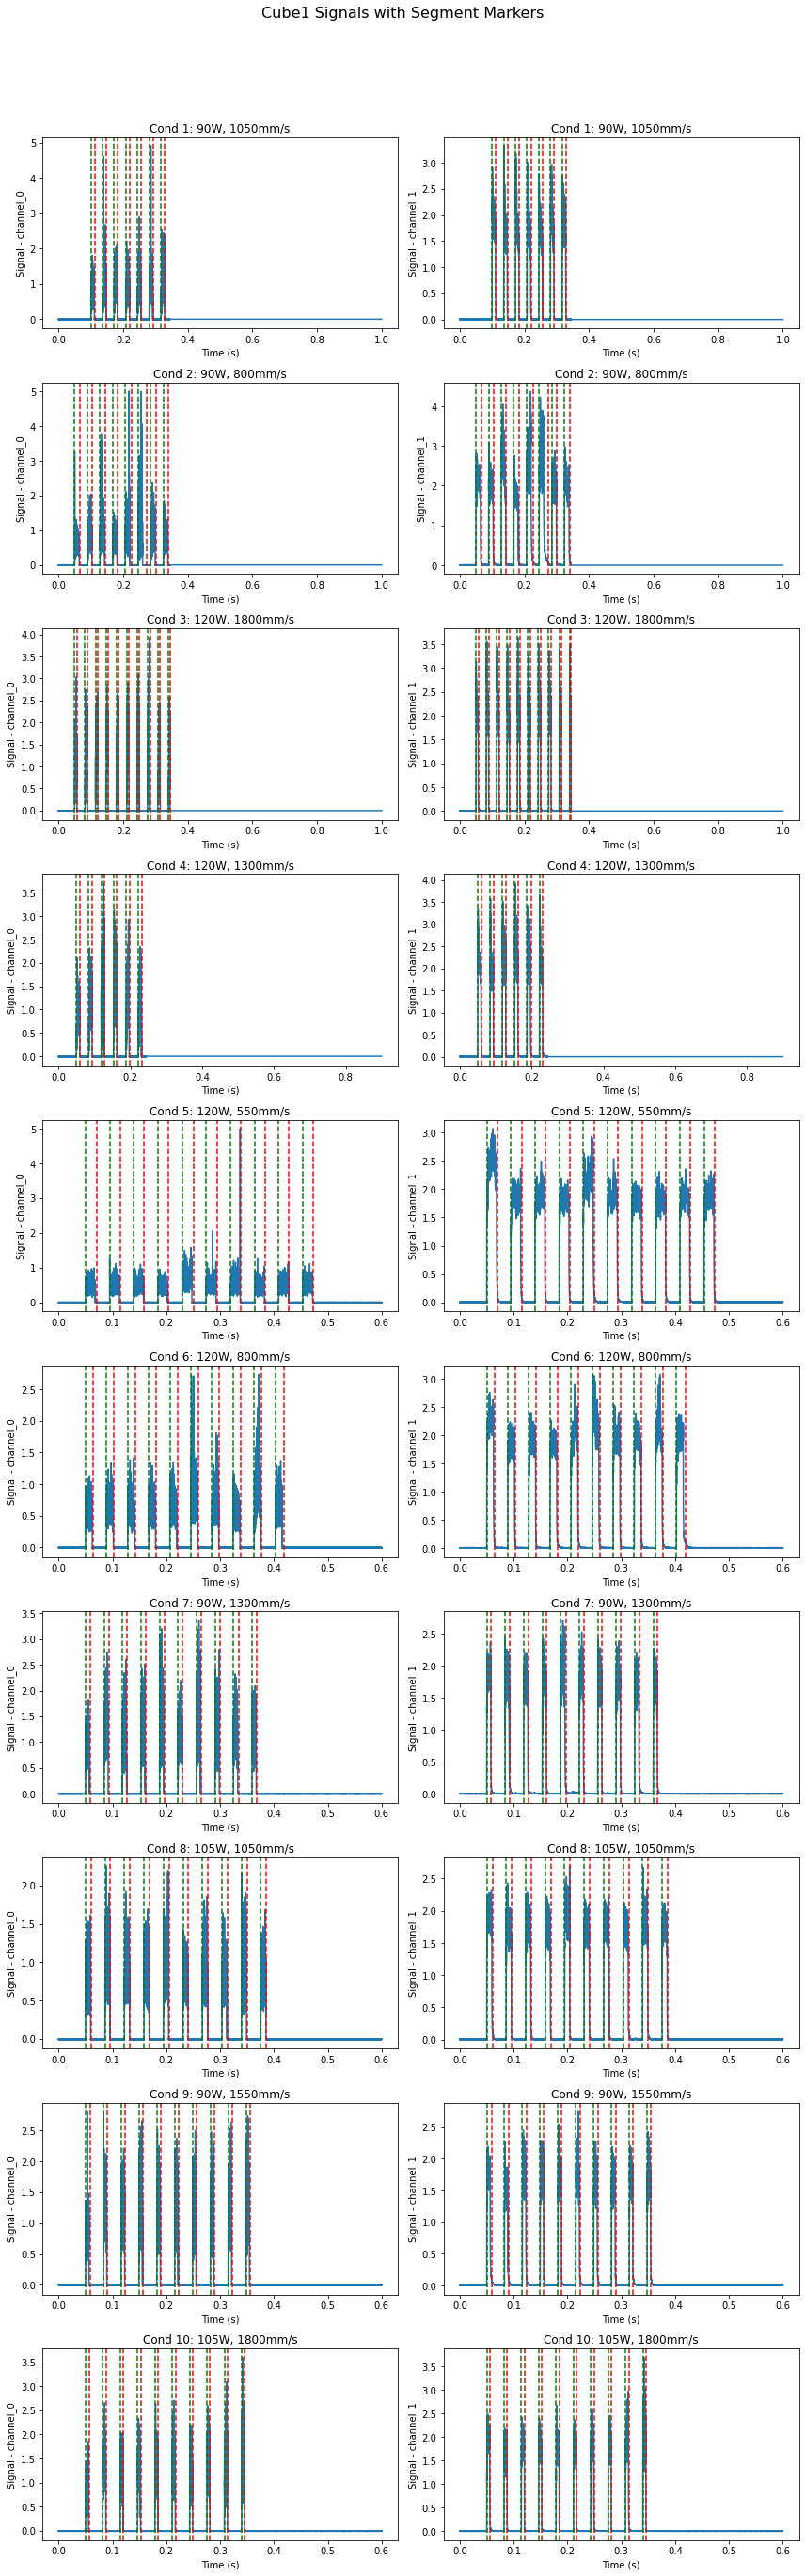

------------------------------
Working on cube 2
Condition 1: Found 11 segments, Avg. Size: 2781.27, Std. Dev: 51.25
Condition 2: Found 10 segments, Avg. Size: 7048.90, Std. Dev: 80.66
Condition 3: Found 10 segments, Avg. Size: 1697.40, Std. Dev: 117.57
Condition 4: Found 10 segments, Avg. Size: 2075.10, Std. Dev: 66.32
Condition 5: Found 10 segments, Avg. Size: 7028.40, Std. Dev: 117.71
Condition 6: Found 10 segments, Avg. Size: 3961.20, Std. Dev: 88.10
Condition 7: Found 10 segments, Avg. Size: 1418.80, Std. Dev: 92.58
Condition 8: Found 10 segments, Avg. Size: 1399.50, Std. Dev: 61.10
Condition 9: Found 9 segments, Avg. Size: 7065.67, Std. Dev: 186.66
Condition 10: Found 11 segments, Avg. Size: 3906.00, Std. Dev: 48.61


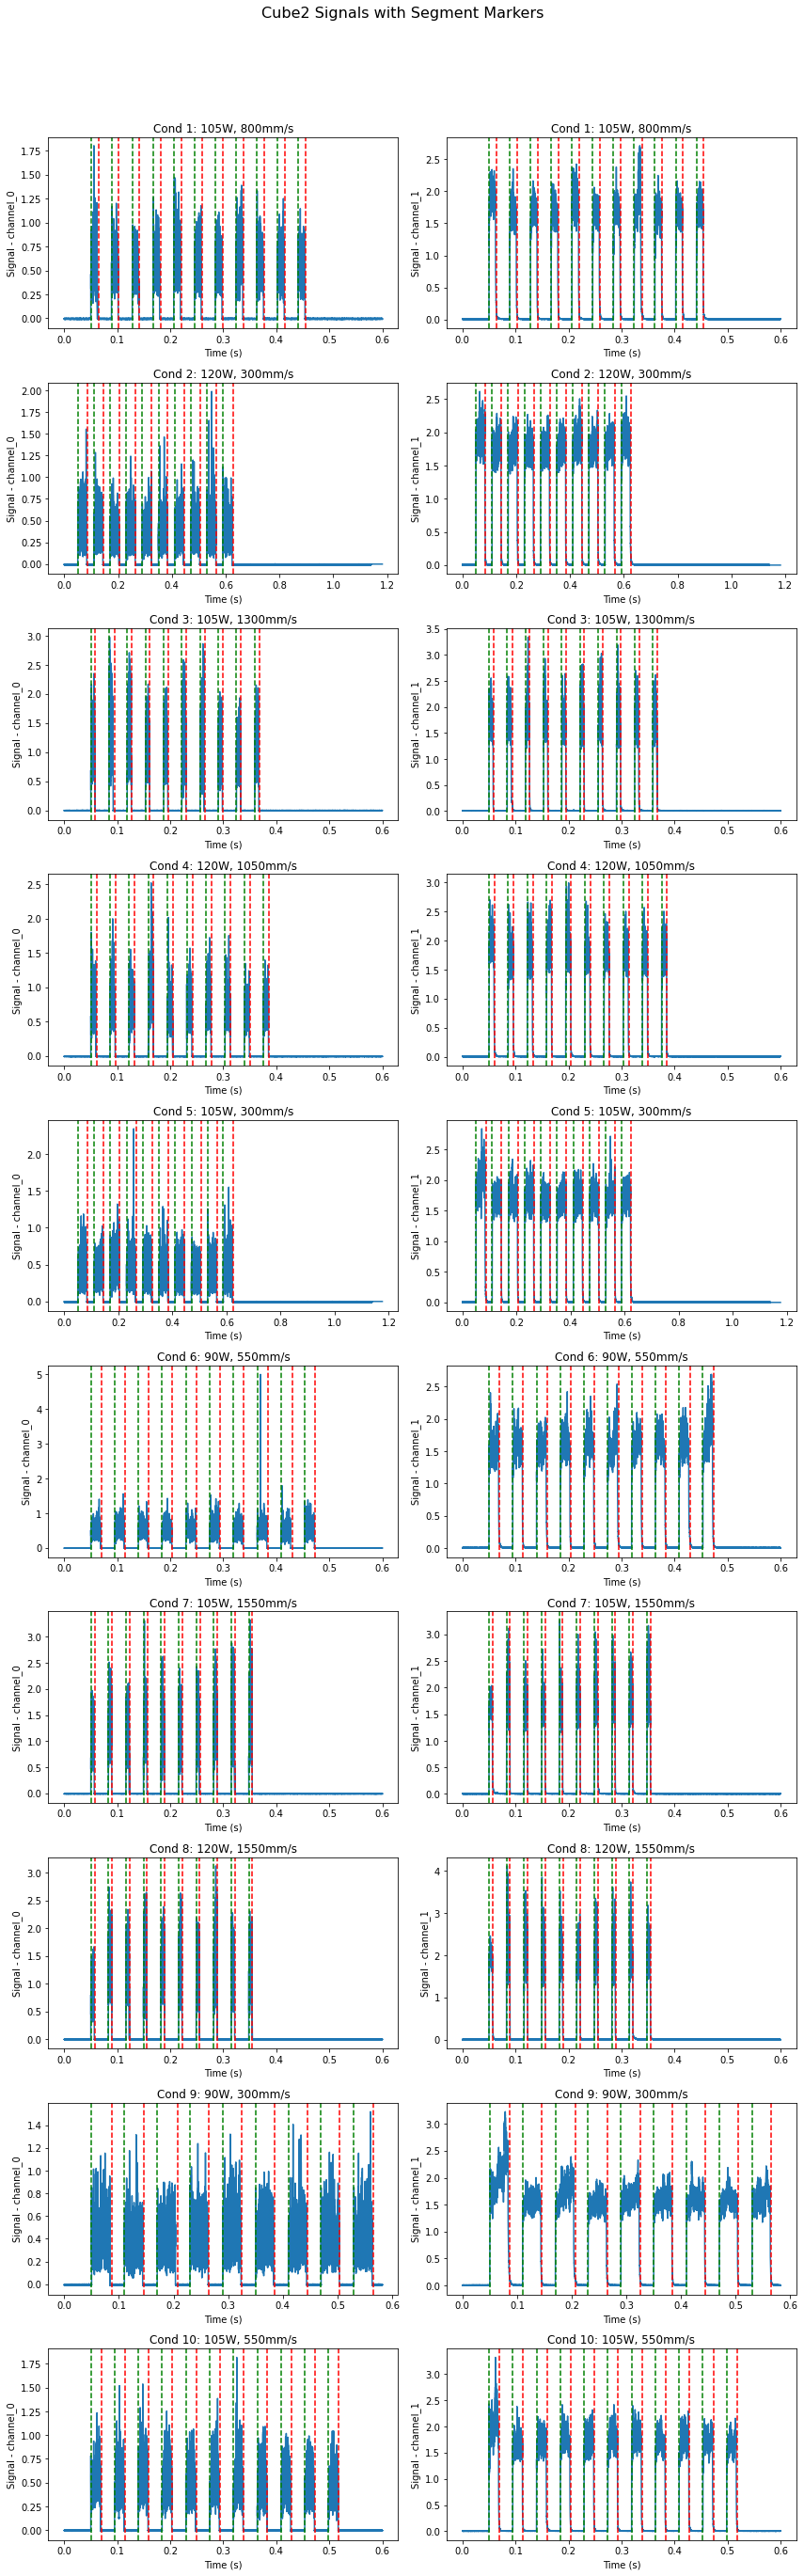

------------------------------
Working on cube 3
Condition 1: Found 10 segments, Avg. Size: 1494.60, Std. Dev: 80.27
Condition 2: Found 10 segments, Avg. Size: 1671.30, Std. Dev: 59.68
Condition 3: Found 10 segments, Avg. Size: 2261.10, Std. Dev: 303.93
Condition 4: Found 10 segments, Avg. Size: 7092.60, Std. Dev: 124.69
Condition 5: Found 10 segments, Avg. Size: 3915.20, Std. Dev: 69.11
Condition 6: Found 10 segments, Avg. Size: 2073.60, Std. Dev: 71.71
Condition 7: Found 10 segments, Avg. Size: 1262.60, Std. Dev: 115.61
Condition 8: Found 10 segments, Avg. Size: 7133.70, Std. Dev: 122.16
Condition 9: Found 10 segments, Avg. Size: 2782.30, Std. Dev: 136.49
Condition 10: Found 10 segments, Avg. Size: 1825.10, Std. Dev: 130.79


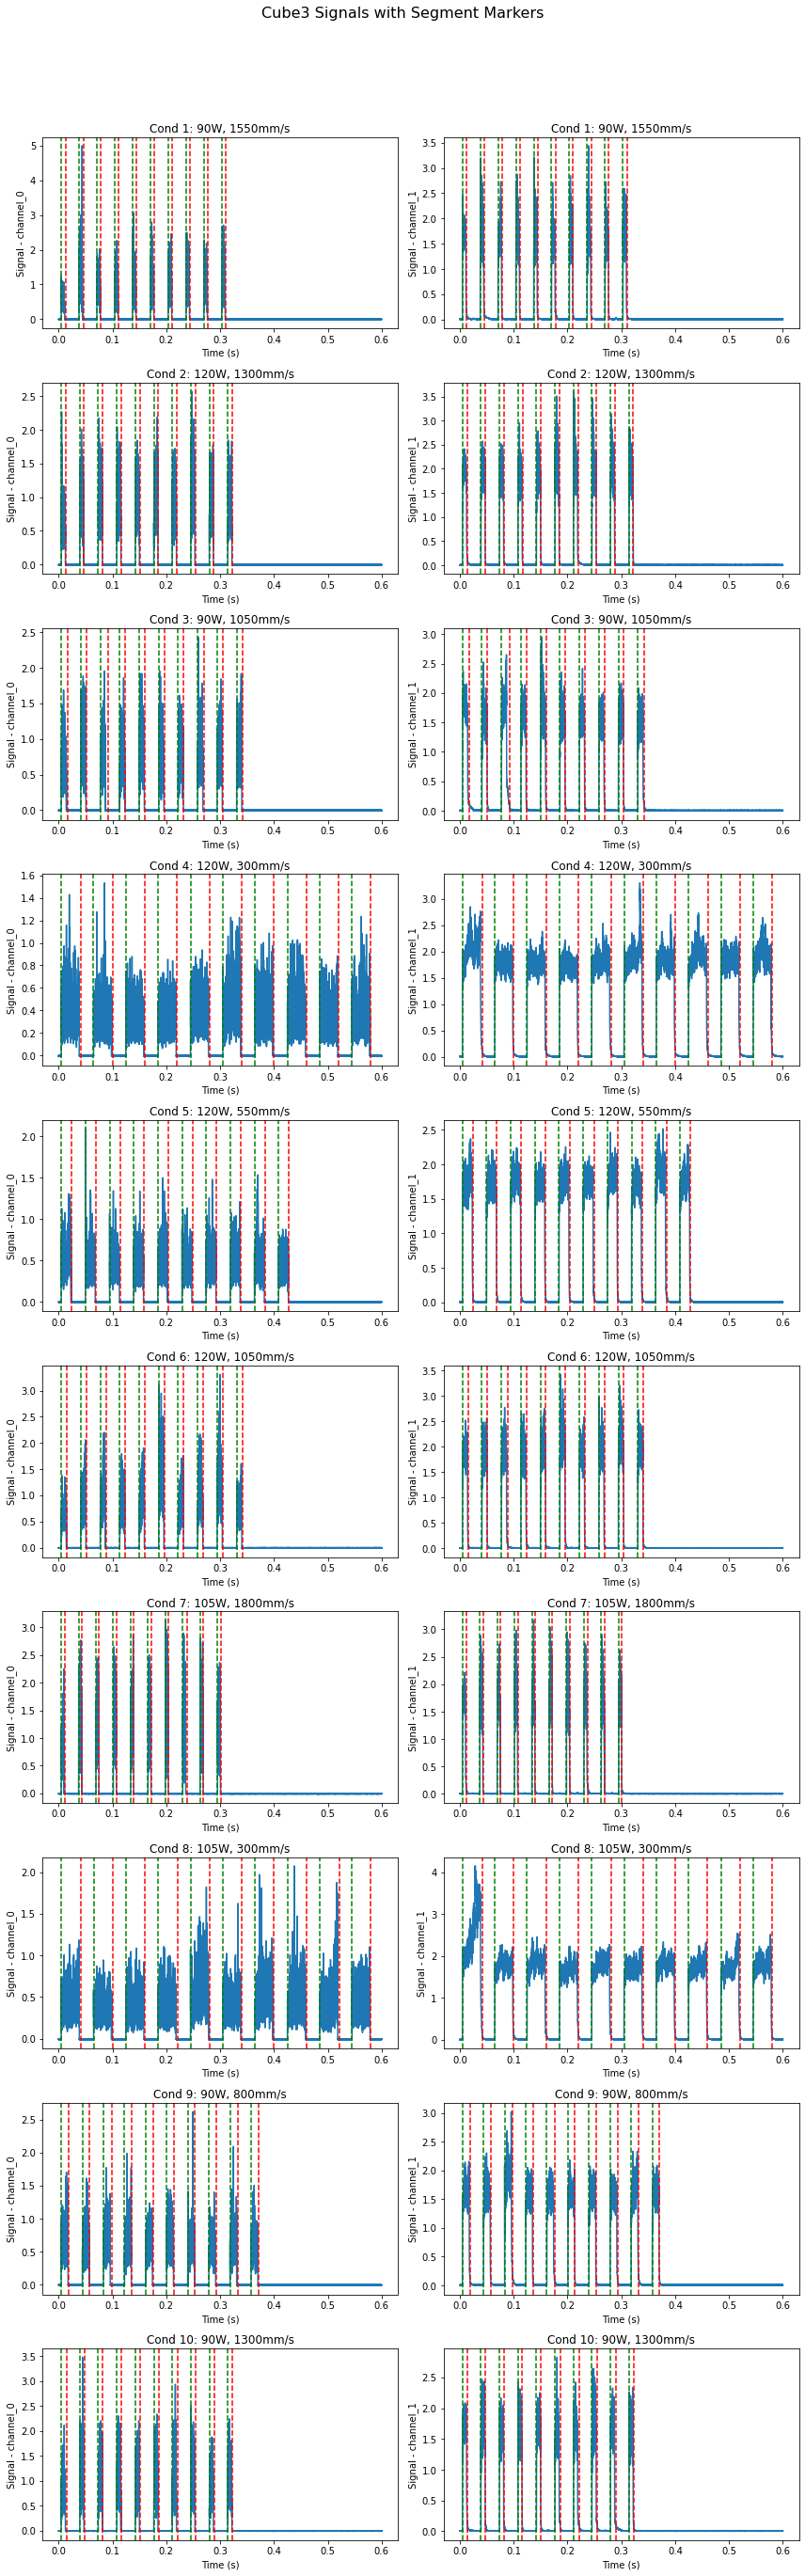

------------------------------
Working on cube 4
Condition 1: Found 10 segments, Avg. Size: 2850.20, Std. Dev: 158.47
Condition 2: Found 10 segments, Avg. Size: 2808.80, Std. Dev: 51.55
Condition 3: Found 10 segments, Avg. Size: 2133.50, Std. Dev: 94.02
Condition 4: Found 10 segments, Avg. Size: 1438.70, Std. Dev: 132.00
Condition 5: Found 10 segments, Avg. Size: 4070.00, Std. Dev: 110.95
Condition 6: Found 10 segments, Avg. Size: 7181.10, Std. Dev: 258.02
Condition 7: Found 10 segments, Avg. Size: 1210.70, Std. Dev: 41.36
Condition 8: Found 10 segments, Avg. Size: 1729.30, Std. Dev: 126.82
Condition 9: Found 10 segments, Avg. Size: 1429.90, Std. Dev: 110.82
Condition 10: Found 10 segments, Avg. Size: 4148.20, Std. Dev: 307.95


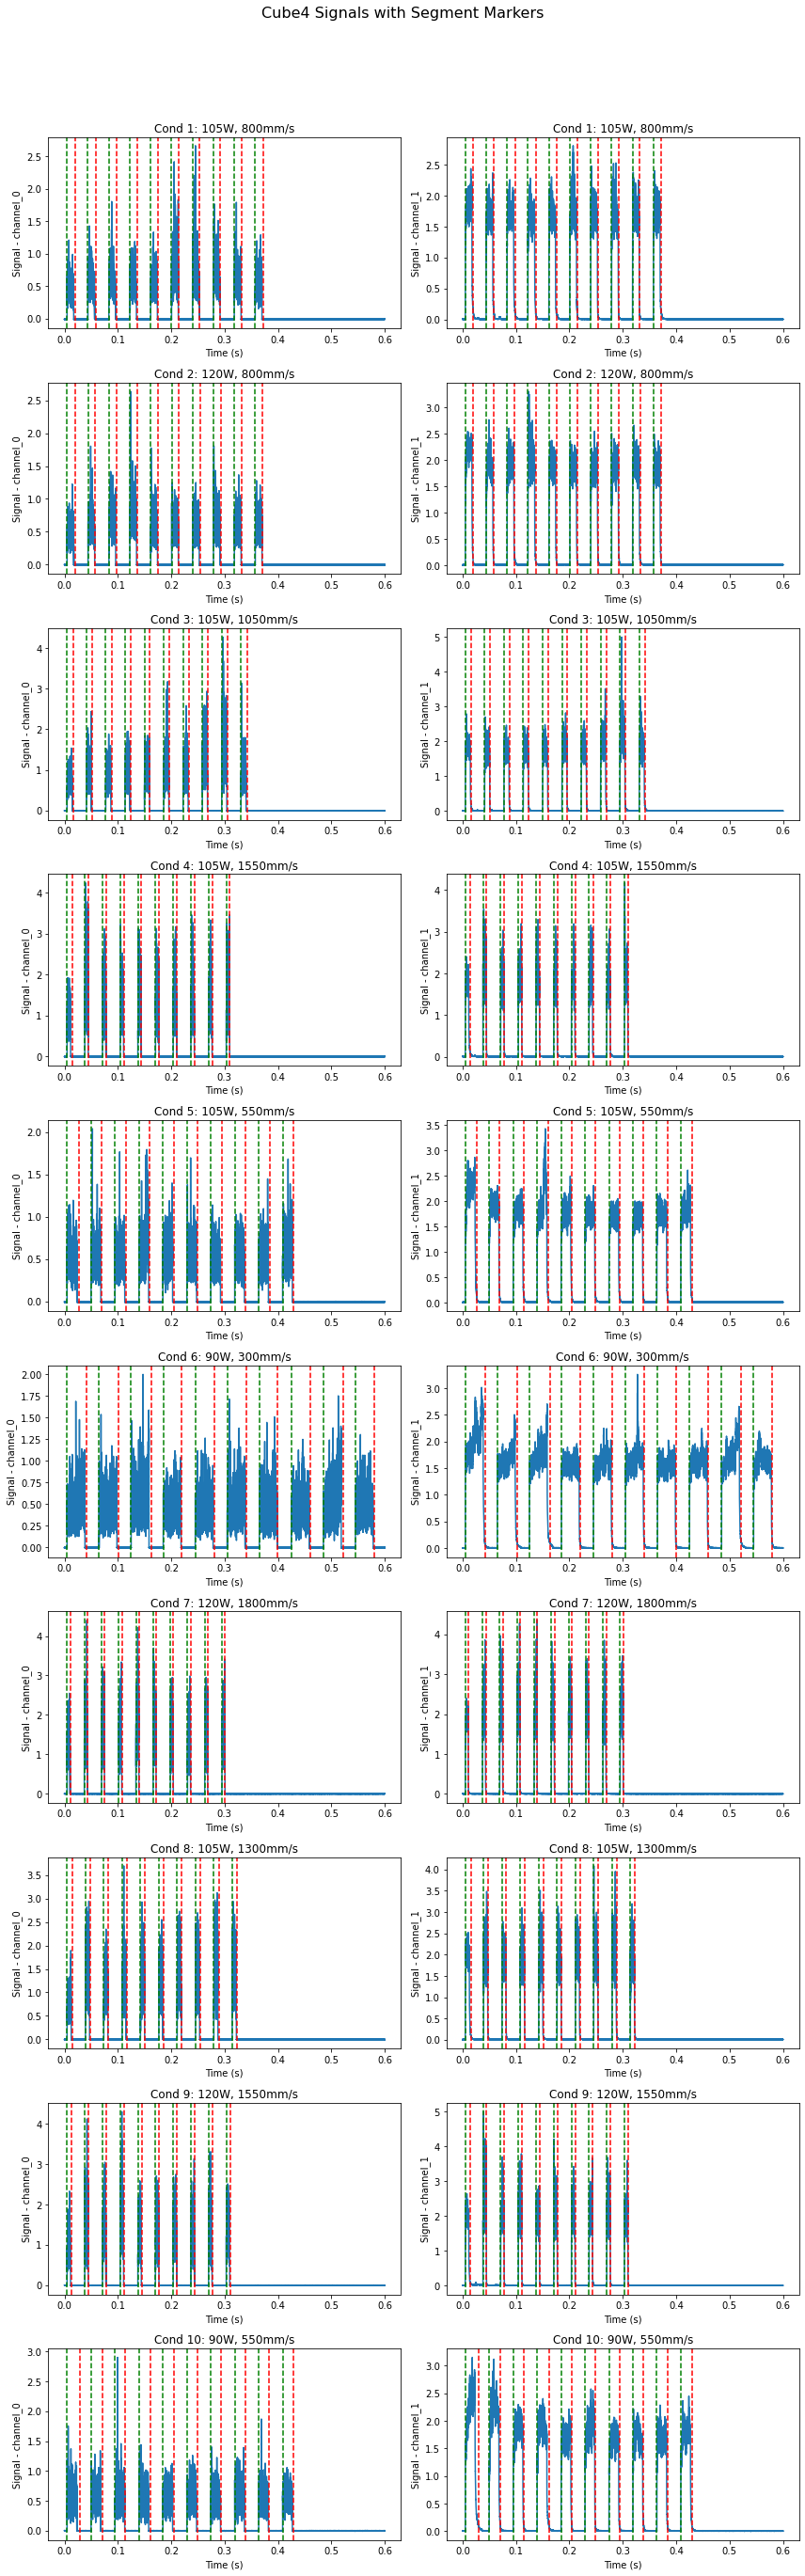

------------------------------
Working on cube 5
Condition 1: Found 10 segments, Avg. Size: 1845.50, Std. Dev: 171.94
Condition 2: Found 10 segments, Avg. Size: 1438.20, Std. Dev: 68.39
Condition 3: Found 10 segments, Avg. Size: 1272.90, Std. Dev: 121.21
Condition 4: Found 10 segments, Avg. Size: 7089.10, Std. Dev: 83.80
Condition 5: Found 11 segments, Avg. Size: 1525.36, Std. Dev: 193.70
Condition 6: Found 11 segments, Avg. Size: 1447.36, Std. Dev: 121.63
Condition 7: Found 10 segments, Avg. Size: 2109.10, Std. Dev: 87.63
Condition 8: Found 10 segments, Avg. Size: 2849.10, Std. Dev: 99.22
Condition 9: Found 10 segments, Avg. Size: 1705.90, Std. Dev: 79.72
Condition 10: Found 10 segments, Avg. Size: 2886.70, Std. Dev: 171.65


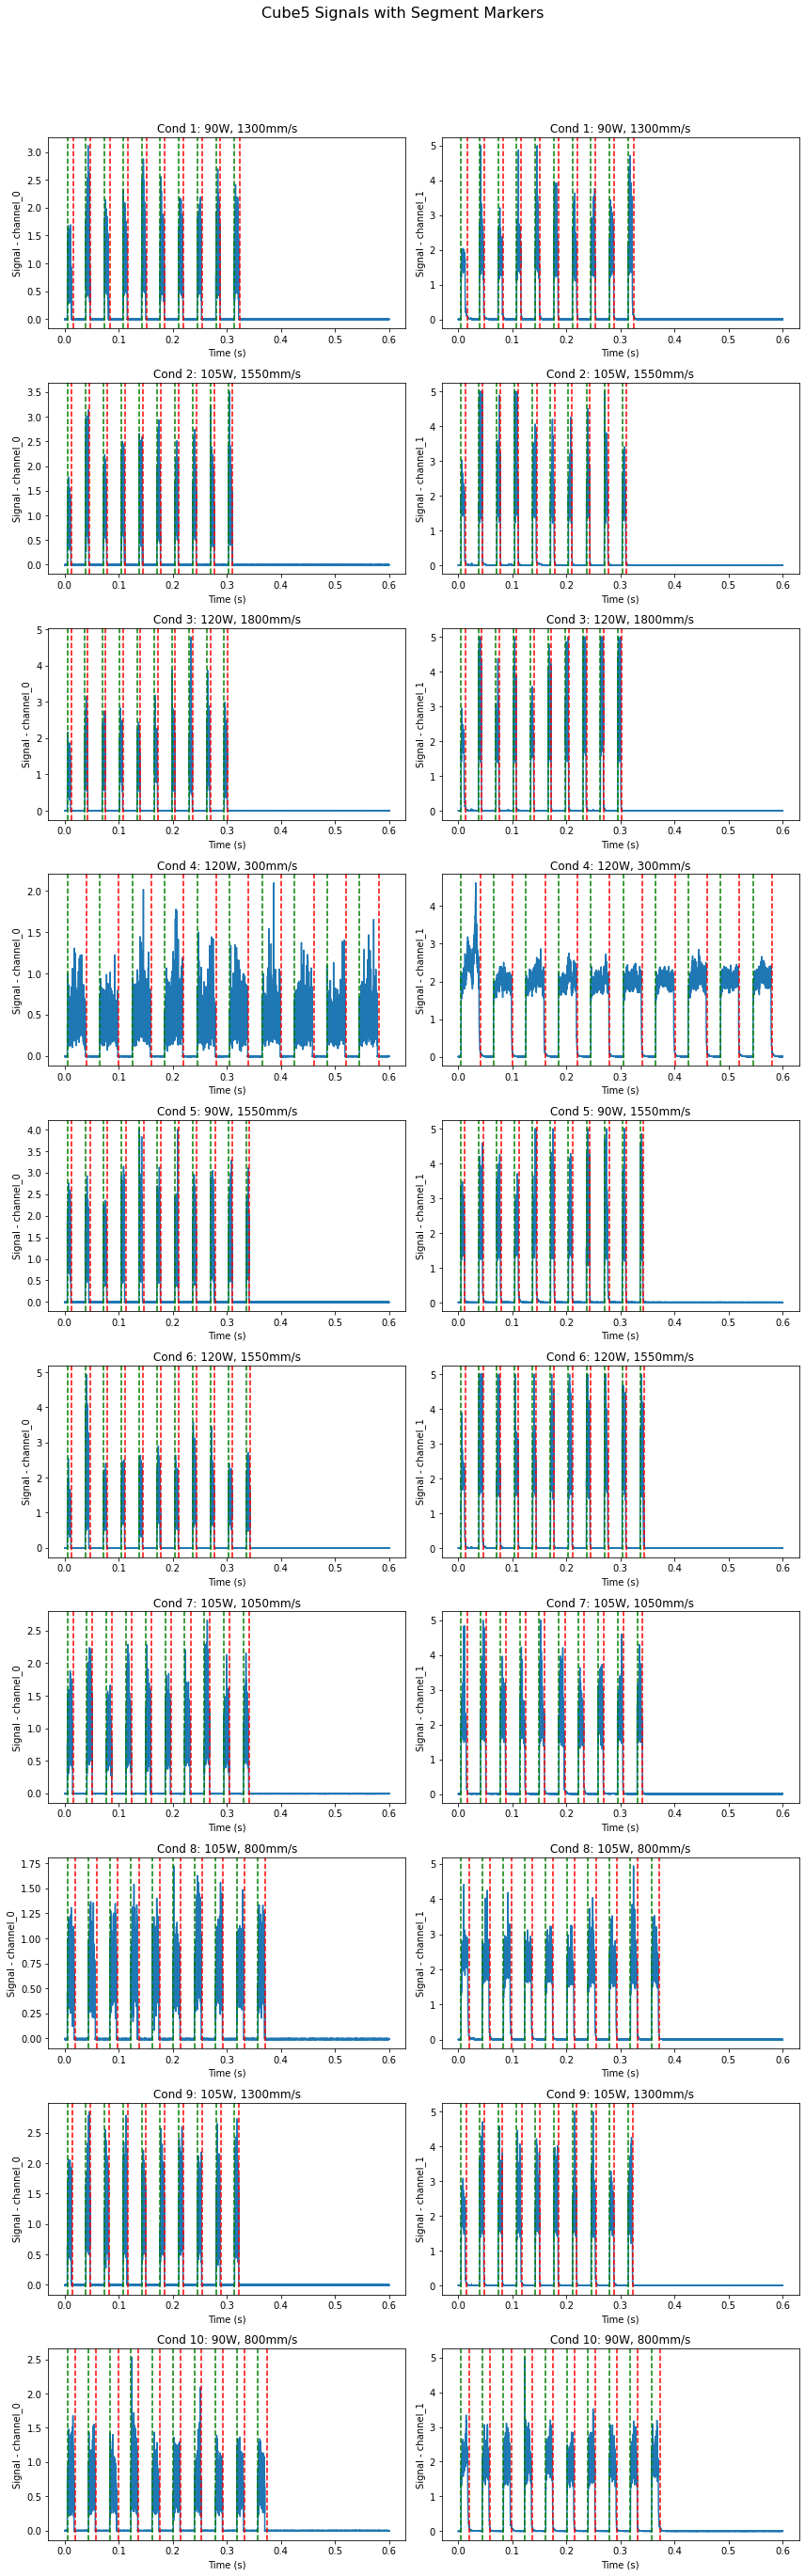

------------------------------
Working on cube 6
Condition 1: Found 10 segments, Avg. Size: 1726.20, Std. Dev: 228.61
Condition 2: Found 10 segments, Avg. Size: 4019.20, Std. Dev: 100.78
Condition 3: Found 10 segments, Avg. Size: 7029.70, Std. Dev: 75.77
Condition 4: Found 10 segments, Avg. Size: 2722.10, Std. Dev: 77.68
Condition 5: Found 10 segments, Avg. Size: 2346.80, Std. Dev: 292.65
Condition 6: Found 10 segments, Avg. Size: 3991.30, Std. Dev: 98.36
Condition 7: Found 10 segments, Avg. Size: 1351.60, Std. Dev: 75.74
Condition 8: Found 10 segments, Avg. Size: 7124.70, Std. Dev: 240.85
Condition 9: Found 10 segments, Avg. Size: 4010.60, Std. Dev: 137.41
Condition 10: Found 10 segments, Avg. Size: 2378.70, Std. Dev: 264.22


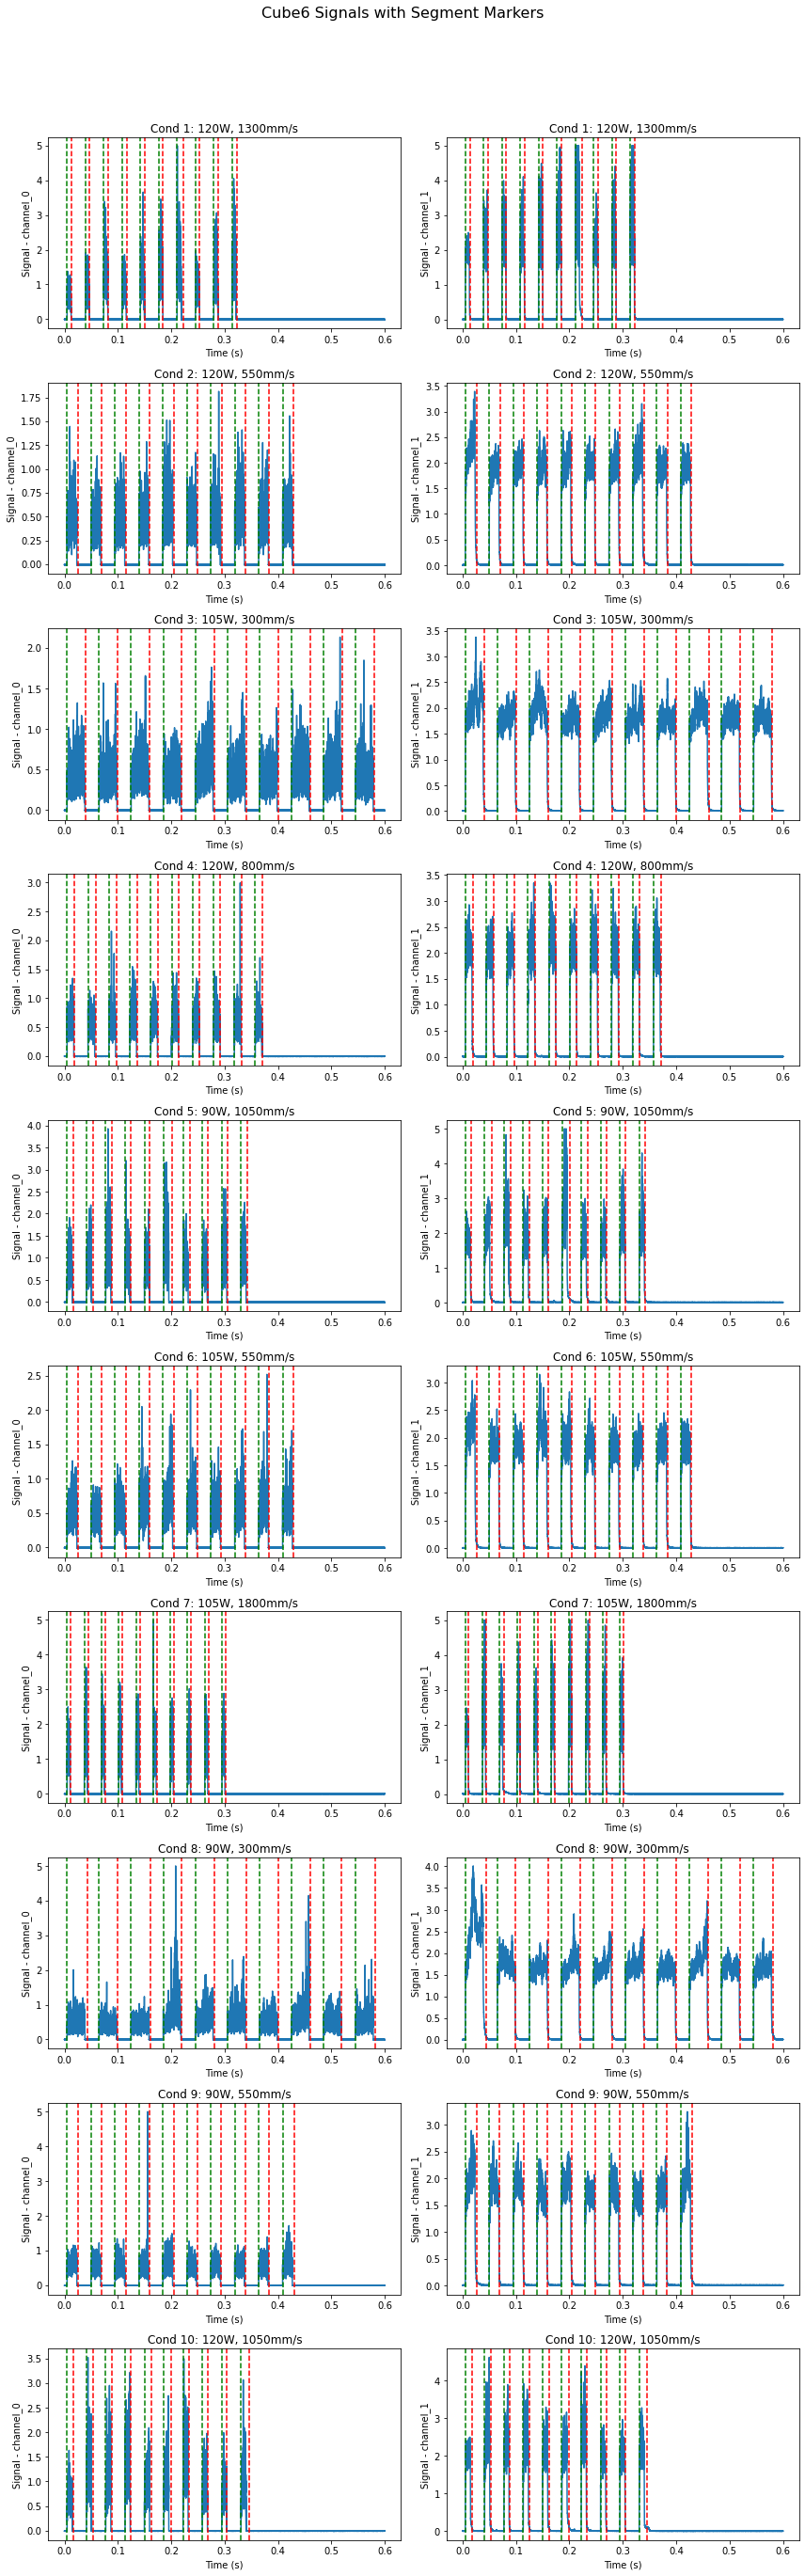

------------------------------
Working on cube 7
Condition 1: Found 10 segments, Avg. Size: 7066.10, Std. Dev: 143.05
Condition 2: Found 10 segments, Avg. Size: 1289.10, Std. Dev: 22.58
Condition 3: Found 10 segments, Avg. Size: 1436.30, Std. Dev: 30.26
Condition 4: Found 10 segments, Avg. Size: 5682.30, Std. Dev: 157.00
Condition 5: Found 10 segments, Avg. Size: 2279.10, Std. Dev: 37.93
Condition 6: Found 10 segments, Avg. Size: 3156.30, Std. Dev: 108.09
Condition 7: Found 10 segments, Avg. Size: 1891.70, Std. Dev: 205.49
Condition 8: Found 10 segments, Avg. Size: 4083.80, Std. Dev: 108.79
Condition 9: Found 10 segments, Avg. Size: 1343.90, Std. Dev: 77.26
Condition 10: Found 10 segments, Avg. Size: 1464.60, Std. Dev: 127.50


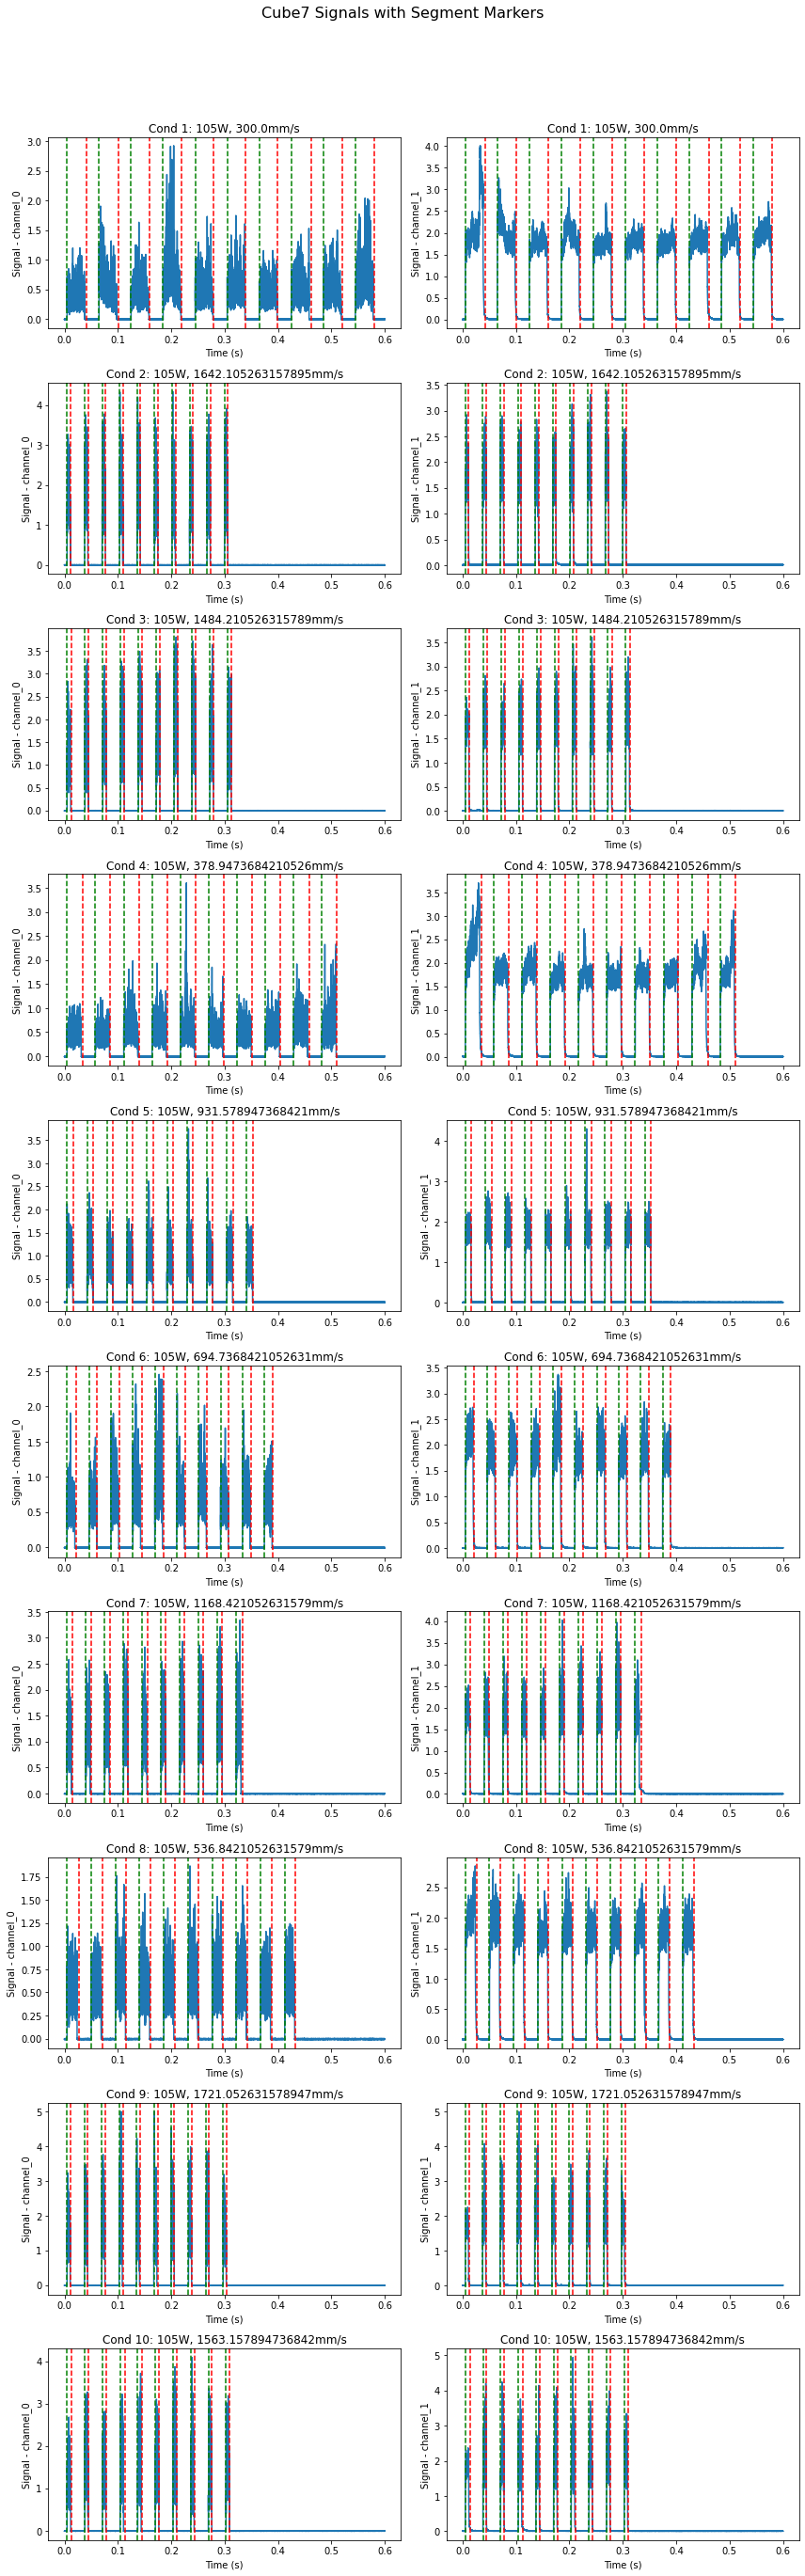

------------------------------
Working on cube 8
Condition 1: Found 11 segments, Avg. Size: 1650.82, Std. Dev: 138.00
Condition 2: Found 11 segments, Avg. Size: 4788.09, Std. Dev: 231.35
Condition 3: Found 10 segments, Avg. Size: 2133.60, Std. Dev: 57.51
Condition 4: Found 11 segments, Avg. Size: 1286.64, Std. Dev: 155.37
Condition 5: Found 11 segments, Avg. Size: 3701.73, Std. Dev: 241.19
Condition 6: Found 10 segments, Avg. Size: 1815.50, Std. Dev: 111.57
Condition 7: Found 10 segments, Avg. Size: 2715.00, Std. Dev: 143.71
Condition 8: Found 10 segments, Avg. Size: 2099.00, Std. Dev: 167.82
Condition 9: Found 11 segments, Avg. Size: 1597.18, Std. Dev: 294.91
Condition 10: Found 11 segments, Avg. Size: 2880.91, Std. Dev: 320.47


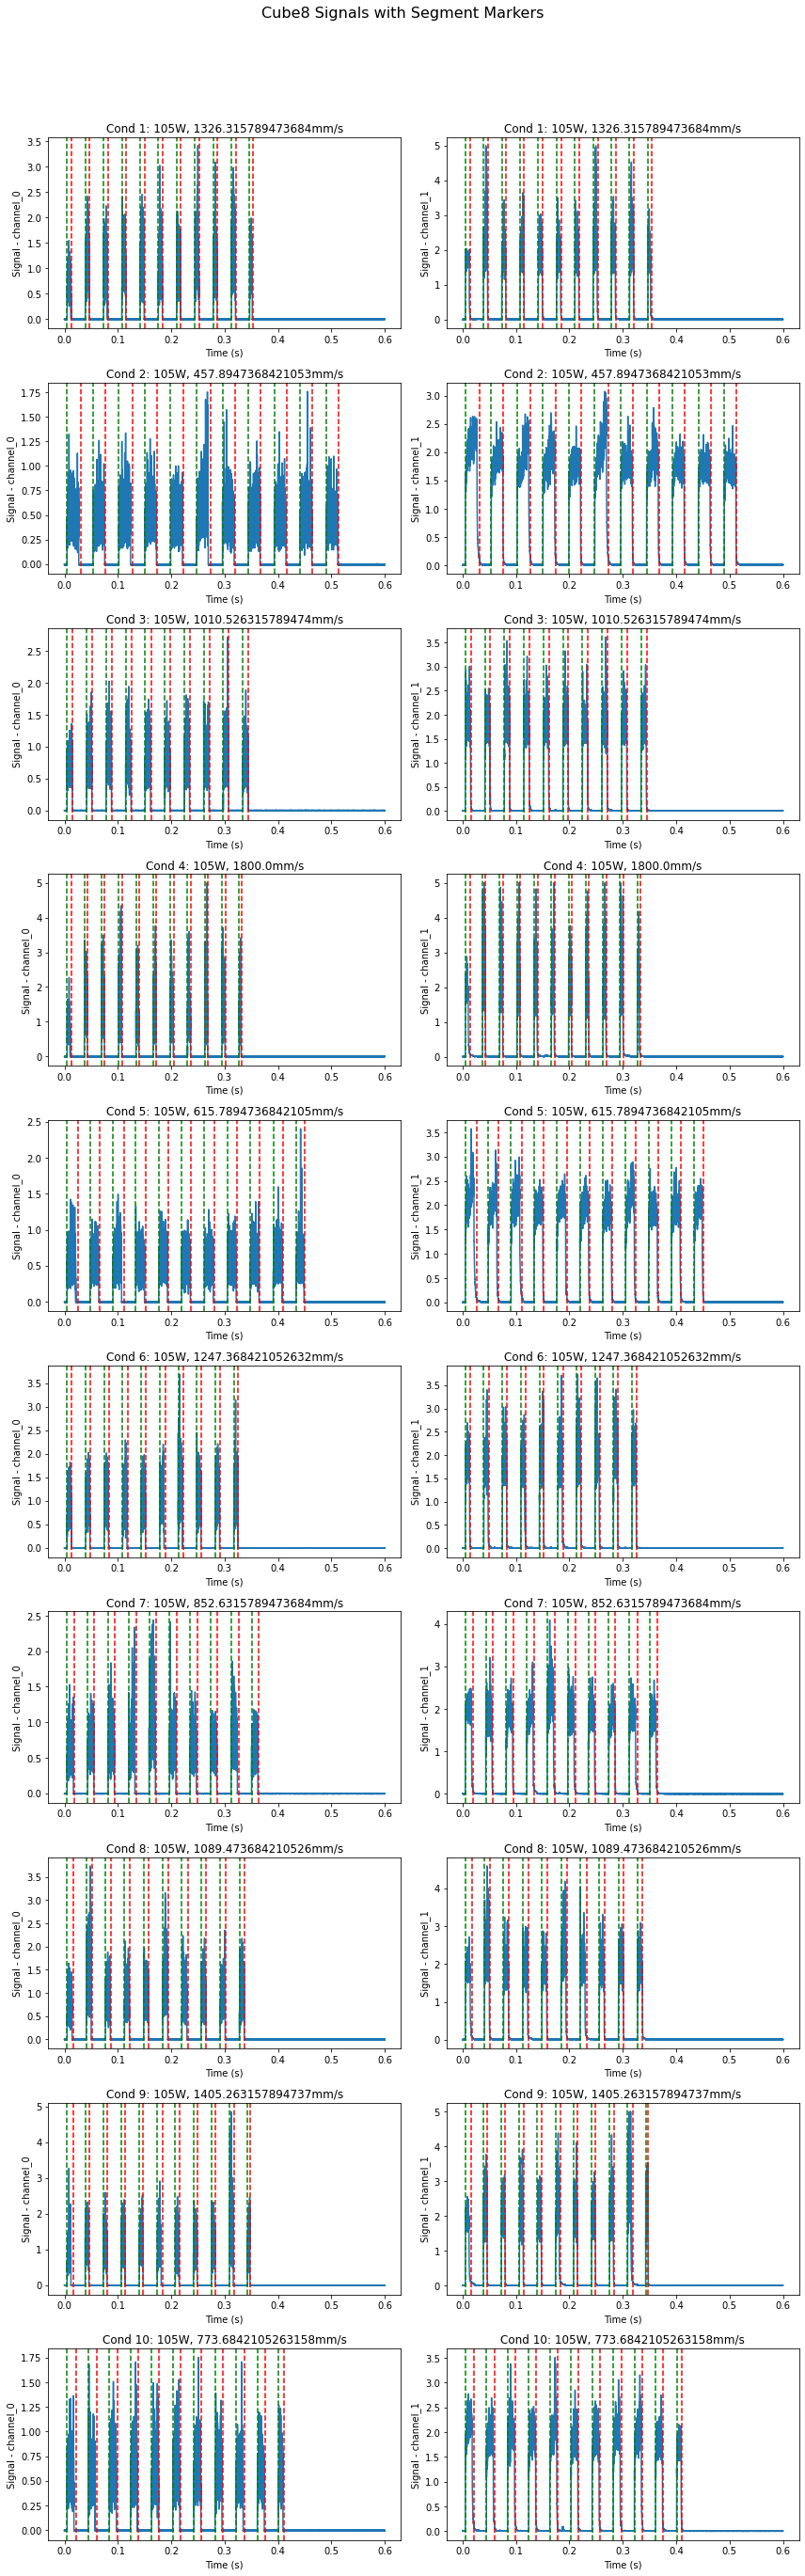

------------------------------
Working on cube 9
Condition 1: Found 10 segments, Avg. Size: 2431.40, Std. Dev: 569.96
Condition 2: Found 10 segments, Avg. Size: 2944.70, Std. Dev: 332.03
Condition 3: Found 10 segments, Avg. Size: 1580.00, Std. Dev: 521.84
Condition 4: Found 10 segments, Avg. Size: 1789.80, Std. Dev: 174.15
Condition 5: Found 10 segments, Avg. Size: 3942.10, Std. Dev: 67.45
Condition 6: Found 10 segments, Avg. Size: 2796.60, Std. Dev: 114.36
Condition 7: Found 10 segments, Avg. Size: 1827.30, Std. Dev: 180.04
Condition 8: Found 10 segments, Avg. Size: 2108.00, Std. Dev: 108.45
Condition 9: Found 10 segments, Avg. Size: 1529.70, Std. Dev: 96.56
Condition 10: Found 10 segments, Avg. Size: 1383.00, Std. Dev: 154.67


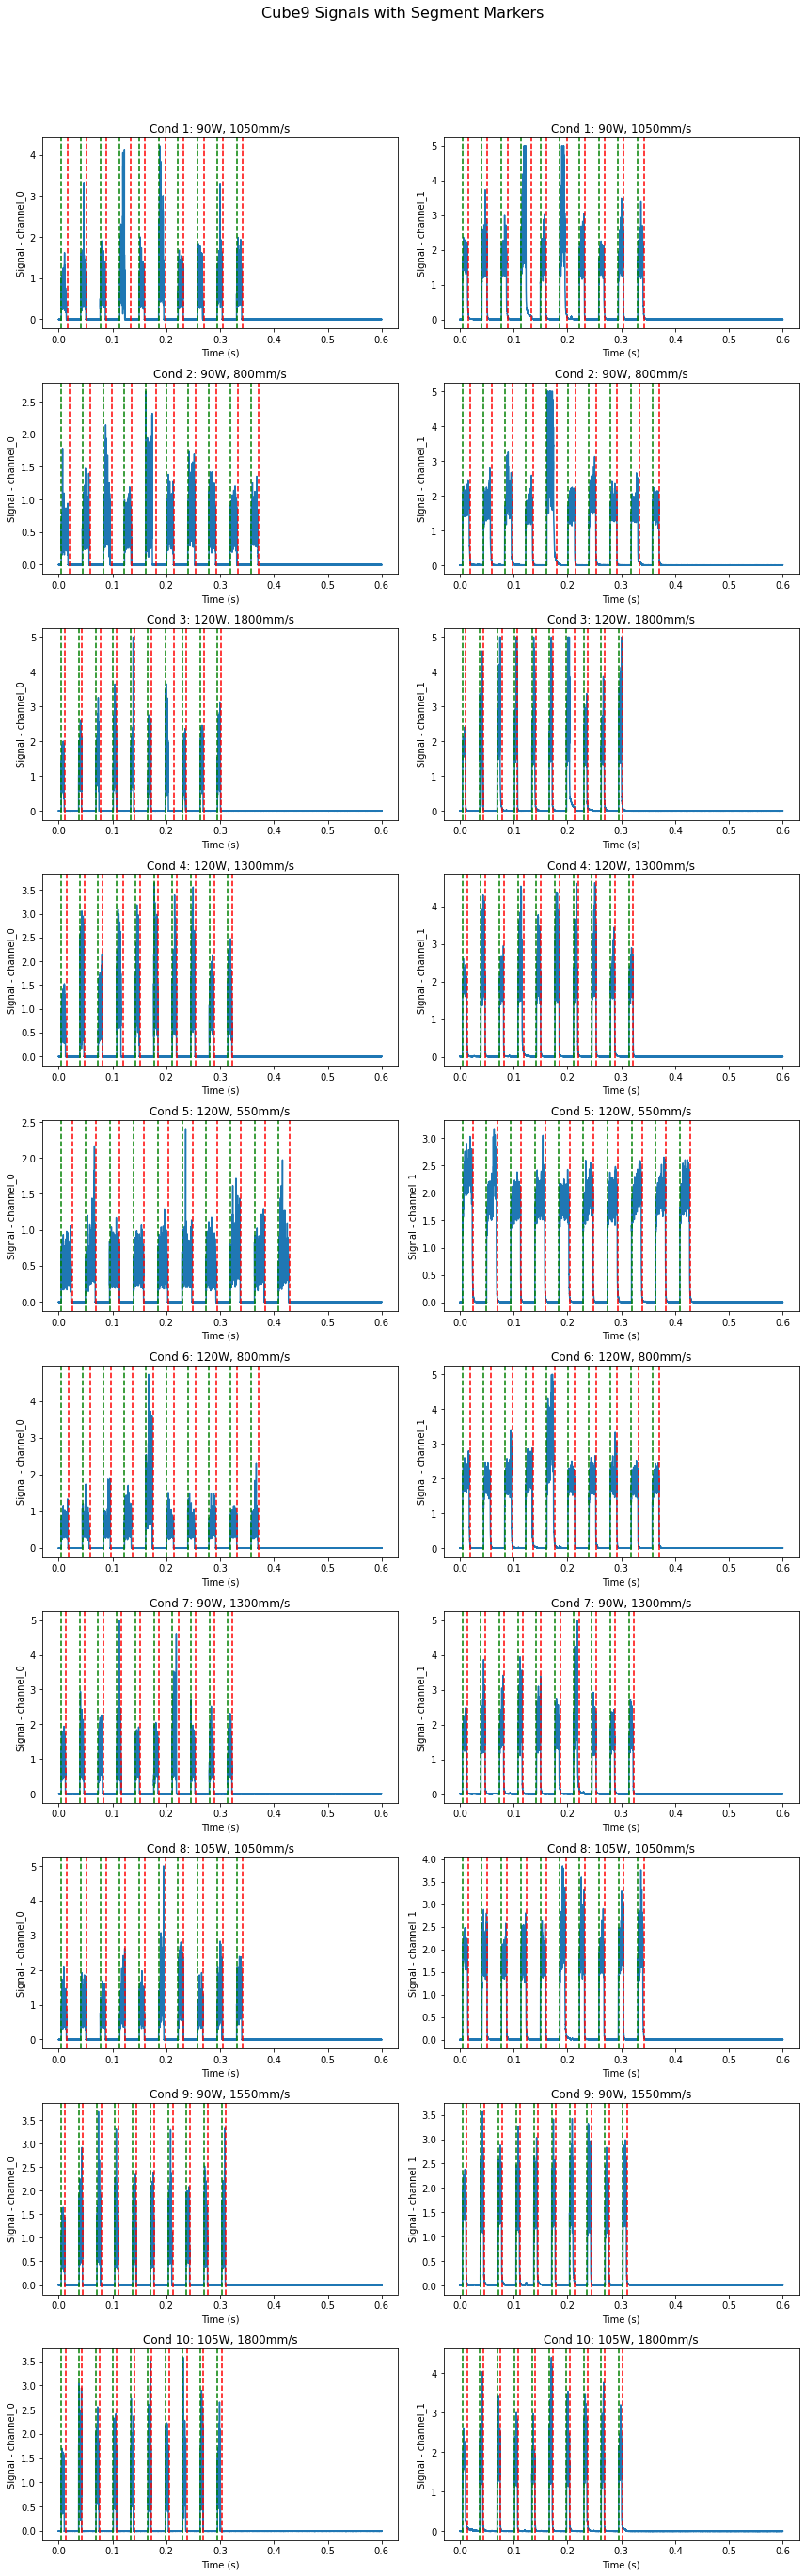

------------------------------


In [5]:
for cube_number in range(1, 10):
    print(f'Working on cube {cube_number}')
    plot_and_segment_cube_signals(cube_number, threshold=0.1)  
    print('---'*10)

In [6]:
segmented_data_dict

{(90,
  1050,
  1): array([[[ 0.5793762 ,  0.5885315 ,  0.5255127 , ..., -0.00518799,
          -0.00305176, -0.00366211],
         [ 0.112915  ,  0.227356  ,  0.3207397 , ...,  0.2140808 ,
           0.2122498 ,  0.2093506 ]],
 
        [[ 0.4139709 ,  0.2906799 ,  0.2557373 , ..., -0.00259399,
          -0.0050354 , -0.00442505],
         [ 0.138855  ,  0.2099609 ,  0.255127  , ...,  0.148468  ,
           0.1467896 ,  0.1426697 ]],
 
        [[ 0.3634644 ,  0.3153992 ,  0.3053284 , ..., -0.00427246,
          -0.00473023,  0.00106811],
         [ 0.1586914 ,  0.2178955 ,  0.2764893 , ...,  0.1083374 ,
           0.1071167 ,  0.1075745 ]],
 
        ...,
 
        [[ 0.2513123 ,  0.3869629 ,  0.4556274 , ..., -0.00732422,
          -0.00473023, -0.00427246],
         [ 0.1469421 ,  0.2404785 ,  0.3695679 , ...,  0.1928711 ,
           0.1980591 ,  0.1916504 ]],
 
        [[ 0.2745056 ,  0.5181885 ,  0.4069519 , ..., -0.00305176,
          -0.00610352, -0.00244141],
         [ 0.14968

In [7]:
def print_segmented_data_summary(segmented_data_dict):
    print("Summary of Segmented Data:")
    for key, tensor in segmented_data_dict.items():
        power, speed, cube_number = key
        print(f"Cube {cube_number}, Power: {power}W, Speed: {speed}mm/s - Tensor Size: {tensor.shape}")

# Call the summary function
print_segmented_data_summary(segmented_data_dict)


Summary of Segmented Data:
Cube 1, Power: 90W, Speed: 1050mm/s - Tensor Size: (7, 2, 2258)
Cube 1, Power: 90W, Speed: 800mm/s - Tensor Size: (8, 2, 2962)
Cube 1, Power: 120W, Speed: 1800mm/s - Tensor Size: (10, 2, 961)
Cube 1, Power: 120W, Speed: 1300mm/s - Tensor Size: (6, 2, 1917)
Cube 1, Power: 120W, Speed: 550mm/s - Tensor Size: (10, 2, 3838)
Cube 1, Power: 120W, Speed: 800mm/s - Tensor Size: (10, 2, 2731)
Cube 1, Power: 90W, Speed: 1300mm/s - Tensor Size: (10, 2, 1609)
Cube 1, Power: 105W, Speed: 1050mm/s - Tensor Size: (10, 2, 1991)
Cube 1, Power: 90W, Speed: 1550mm/s - Tensor Size: (10, 2, 1366)
Cube 1, Power: 105W, Speed: 1800mm/s - Tensor Size: (10, 2, 1173)
Cube 2, Power: 105W, Speed: 800mm/s - Tensor Size: (11, 2, 2720)
Cube 2, Power: 120W, Speed: 300mm/s - Tensor Size: (10, 2, 6969)
Cube 2, Power: 105W, Speed: 1300mm/s - Tensor Size: (10, 2, 1606)
Cube 2, Power: 120W, Speed: 1050mm/s - Tensor Size: (10, 2, 2003)
Cube 2, Power: 105W, Speed: 300mm/s - Tensor Size: (10, 2, 691

In [8]:
import pickle

# Define the path where you want to save the dictionary
pickle_file_path = base_path + '/segmented_data_dict_Ti64.pkl'

# Save the dictionary
with open(pickle_file_path, 'wb') as file:
    pickle.dump(segmented_data_dict, file)

print(f'Saved segmented_data_dict to {pickle_file_path}')


Saved segmented_data_dict to ./Data/Neuchatel_Ti64//segmented_data_dict_Ti64.pkl


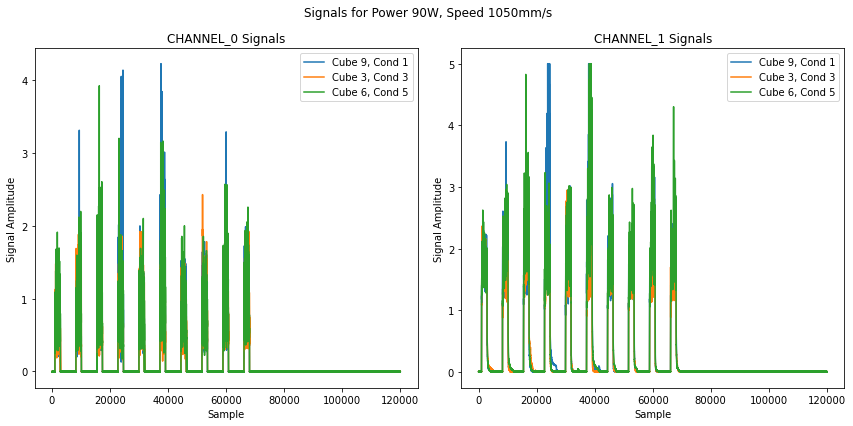

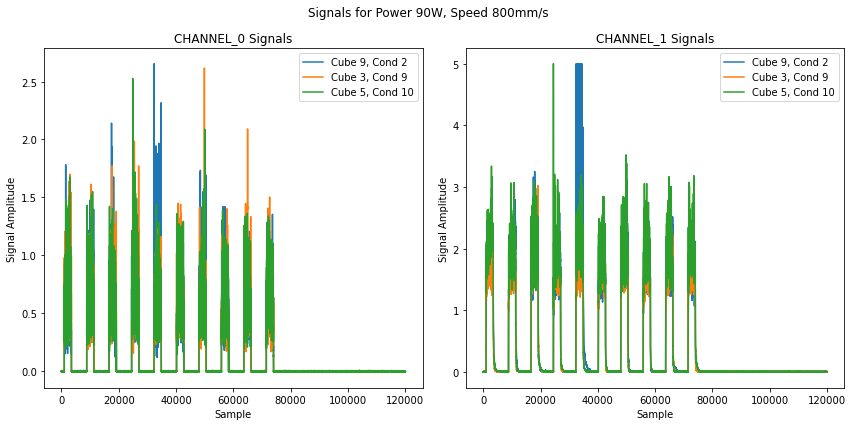

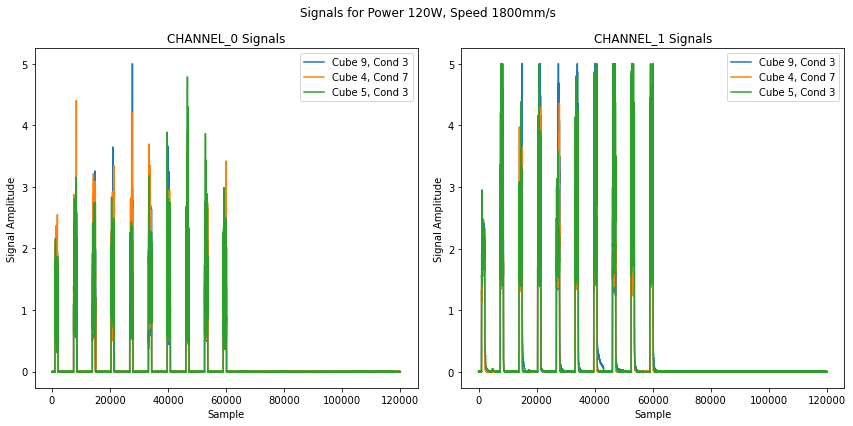

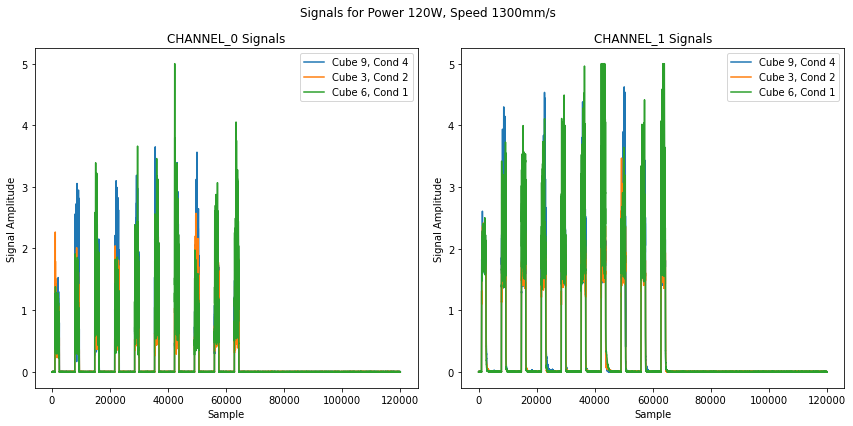

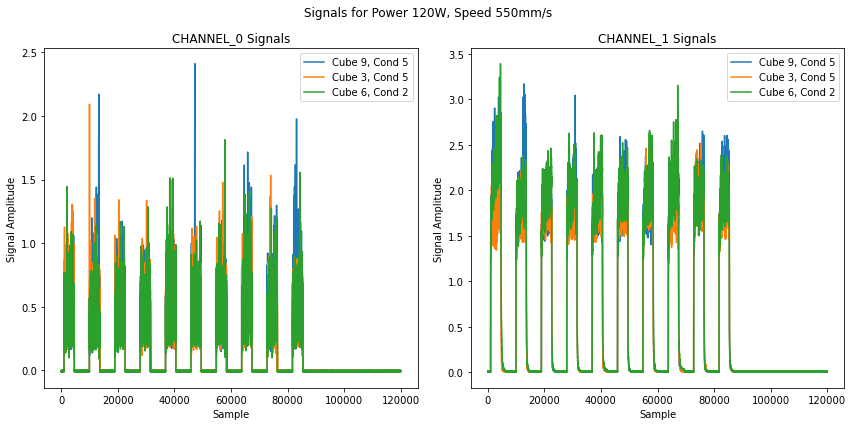

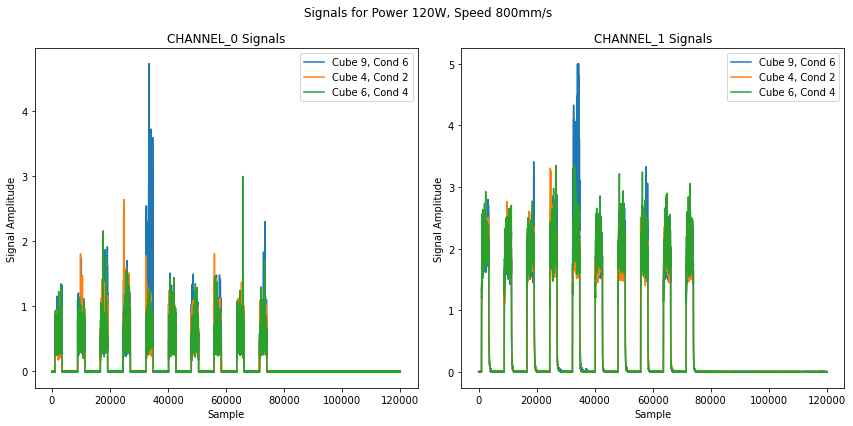

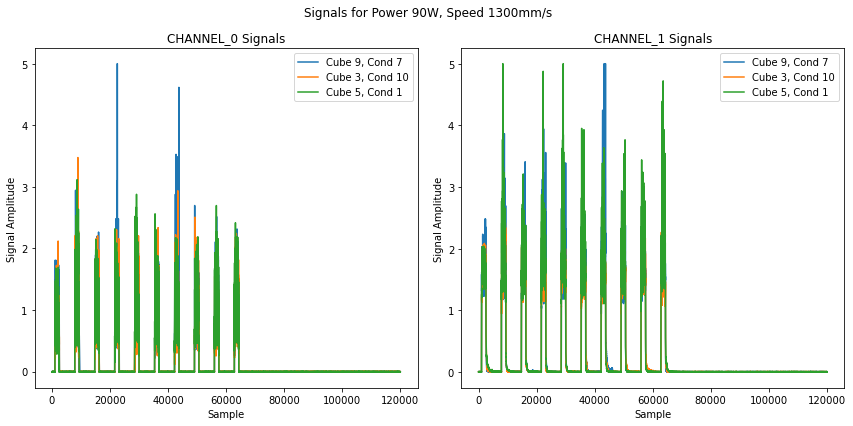

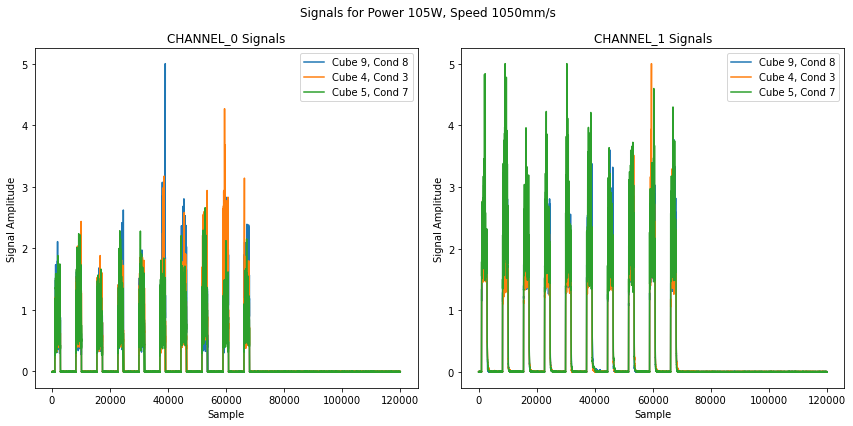

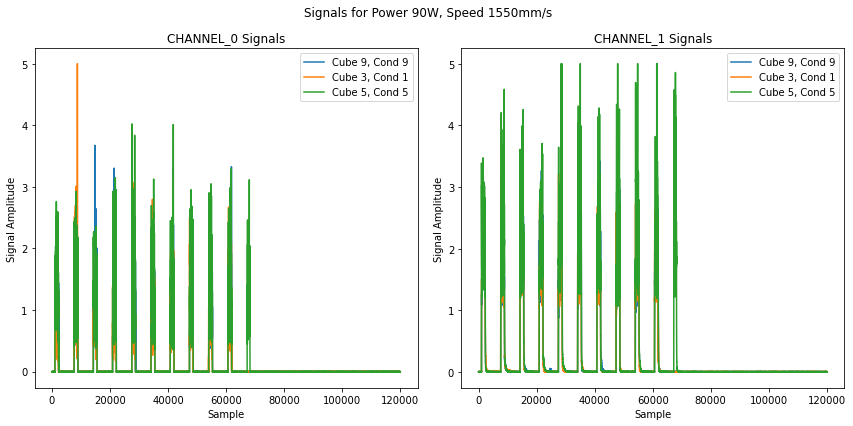

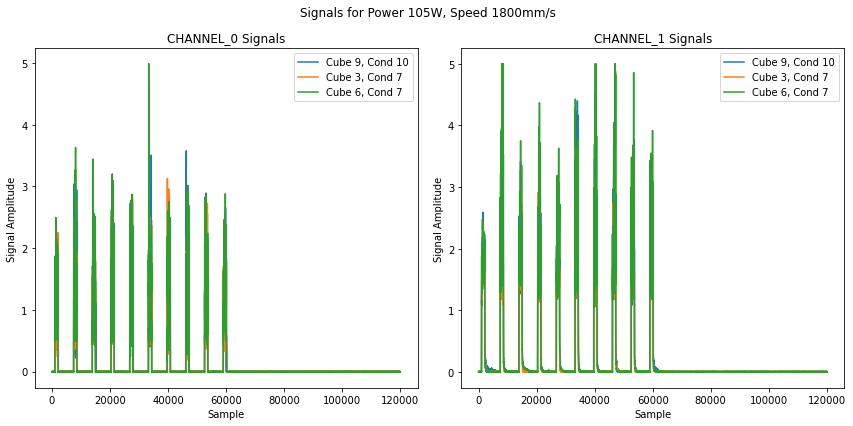

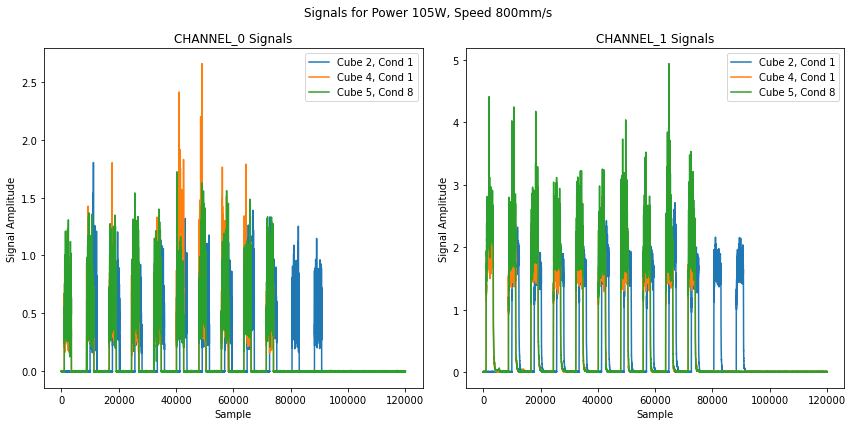

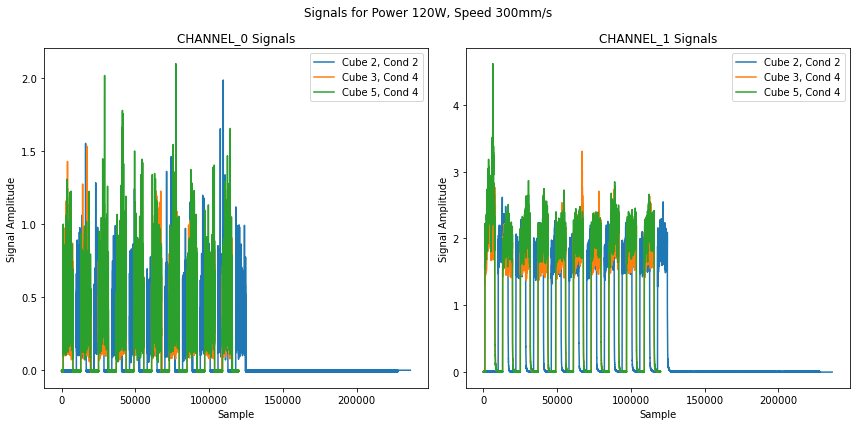

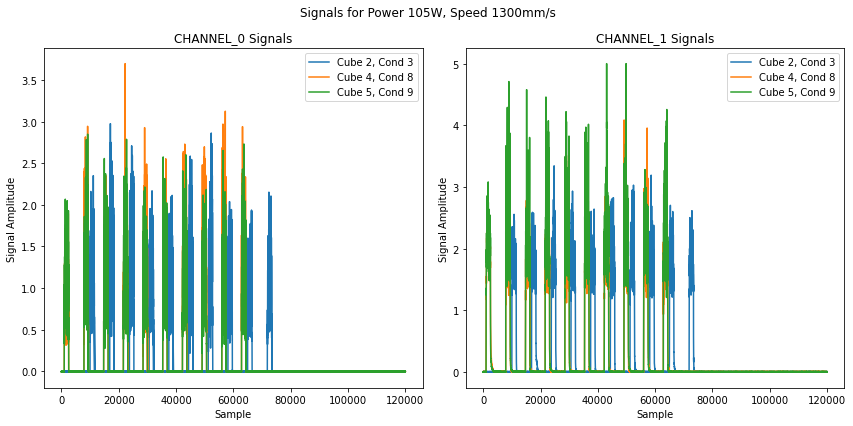

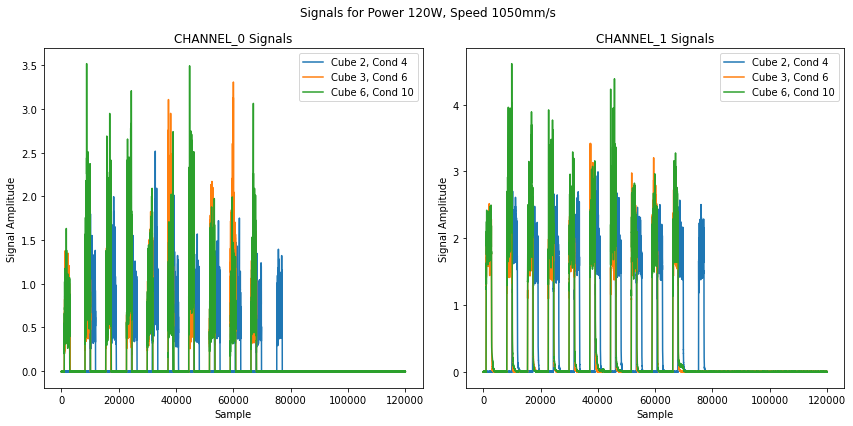

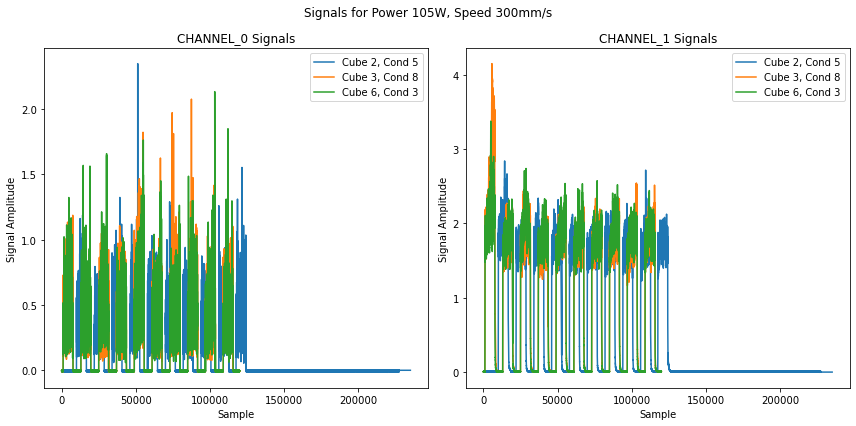

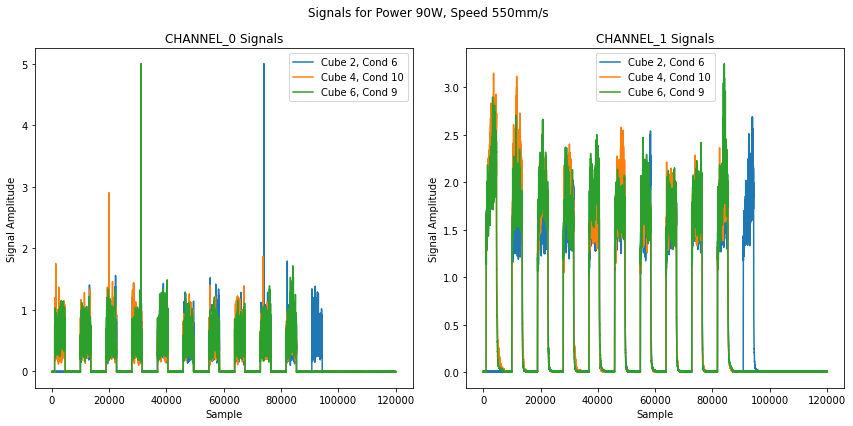

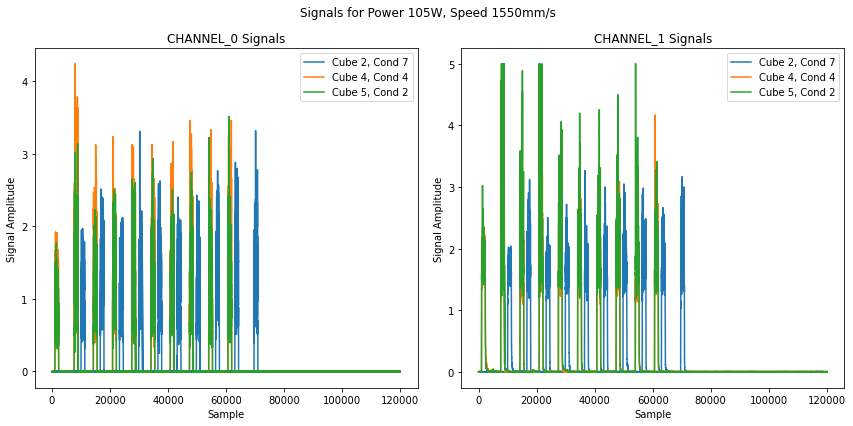

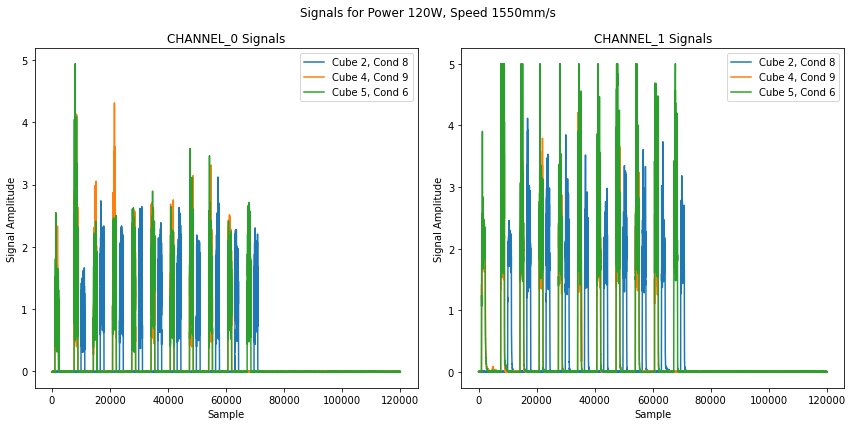

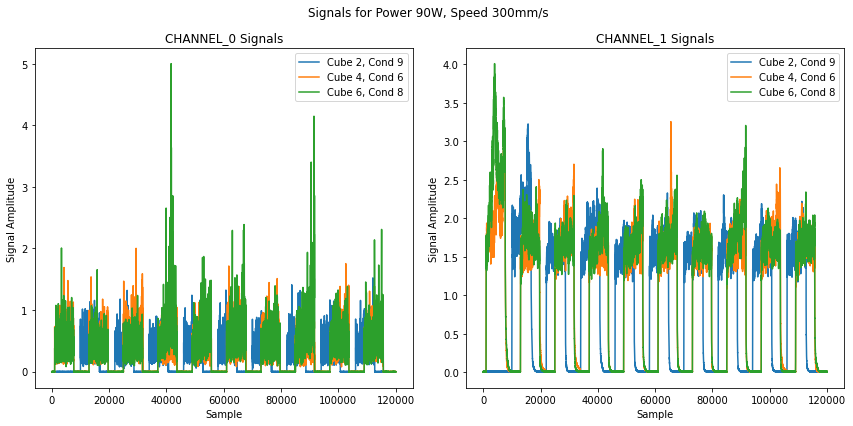

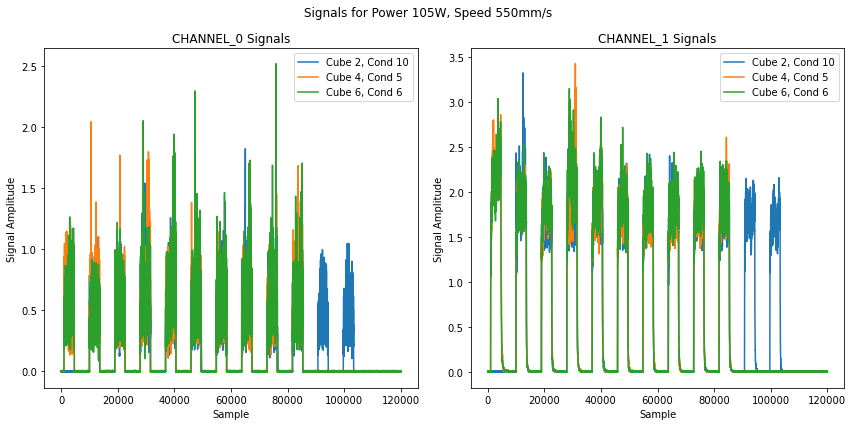

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_concatenated_signals_by_parameters(cubes_list, base_path, params_dict):
 # Initialize a dictionary to store concatenated signals by parameters (without cube number)
    concatenated_signals = {}
    # Enhanced structure to keep track of the source cubes and conditions for each signal part
    signal_sources = {}

    for cube in cubes_list:
        cube_name = f'Cube{cube}'
        cube_path = os.path.join(base_path, cube_name)
        
        for condition in range(10):  # Assuming 10 conditions per cube
            # Load channel data
            data_channel_0 = pd.read_csv(os.path.join(cube_path, 'channel_0', f'File_{condition}.csv')).to_numpy().flatten()
            data_channel_1 = pd.read_csv(os.path.join(cube_path, 'channel_1', f'File_{condition}.csv')).to_numpy().flatten()
            
            # Extract the parameter set for this condition
            param_set = params_dict[cube_name][condition]
            key = (param_set['Power (W)'], param_set['Speed (mm/s)'])
            
            if key not in concatenated_signals:
                concatenated_signals[key] = {'channel_0': [], 'channel_1': []}
                signal_sources[key] = {'channel_0': [], 'channel_1': []}
            
            concatenated_signals[key]['channel_0'].append(data_channel_0)
            concatenated_signals[key]['channel_1'].append(data_channel_1)
            # Now also track condition number along with cube number
            signal_sources[key]['channel_0'].append((cube, condition + 1))  # +1 condition indexing starts at 0
            signal_sources[key]['channel_1'].append((cube, condition + 1))

    # Plotting
    for params, channels_data in concatenated_signals.items():
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f'Signals for Power {params[0]}W, Speed {params[1]}mm/s')
        
        for i, channel in enumerate(['channel_0', 'channel_1']):
            ax = axes[i]
            for signal_index, signal_data in enumerate(channels_data[channel]):
                cube_number, condition_number = signal_sources[params][channel][signal_index]
                # Label now includes both cube number and condition number
                ax.plot(signal_data, label=f'Cube {cube_number}, Cond {condition_number}')
            ax.set_title(f'{channel.upper()} Signals')
            ax.set_xlabel('Sample')
            ax.set_ylabel('Signal Amplitude')
            ax.legend()
        
        plt.tight_layout()
        plt.show()

cubes_list = [9,2,3,4,5,6]  
plot_concatenated_signals_by_parameters(cubes_list, base_path, params_dict)


In [17]:
def segment_and_organize_signals(cubes_list, base_path, params_dict, threshold):
    # Initialize a dictionary to store the tensors for each parameter set
    segmented_data = {}

    for cube in cubes_list:
        cube_name = f'Cube{cube}'
        cube_path = os.path.join(base_path, cube_name)
        
        for condition in range(10):  # Assuming 10 conditions per cube
            # Load channel data
            data_channel_0 = pd.read_csv(os.path.join(cube_path, 'channel_0', f'File_{condition}.csv')).to_numpy().flatten()
            data_channel_1 = pd.read_csv(os.path.join(cube_path, 'channel_1', f'File_{condition}.csv')).to_numpy().flatten()
            
            # Segment channel 1
            starting_1, ending_1 = computeBoundaries(data_channel_1, threshold)
            
            # Determine the length of the shortest segment
            segment_lengths = [end - start for start, end in zip(starting_1, ending_1)]
            min_length = min(segment_lengths)
            
            # Extract the parameter set for this condition
            param_set = params_dict[cube_name][condition]
            key = (param_set['Power (W)'], param_set['Speed (mm/s)'])
            
            if key not in segmented_data:
                segmented_data[key] = []

            # Segment and store data for both channels using the boundaries found in channel 1
            for start, end in zip(starting_1, ending_1):
                segment = np.zeros((2, min_length))
                segment[0, :] = data_channel_0[start:start+min_length]
                segment[1, :] = data_channel_1[start:start+min_length]
                segmented_data[key].append(segment)
    
    # Convert lists to tensors and adjust to have uniform shape (N, 2, M)
    for key, segments in segmented_data.items():
        total_segments = len(segments)
        if total_segments == 0:
            continue
        min_segment_length = min(segment.shape[1] for segment in segments)
        tensor_shape = (total_segments, 2, min_segment_length)
        tensor = np.zeros(tensor_shape)
        for i, segment in enumerate(segments):
            tensor[i, :, :] = segment[:, :min_segment_length]
        segmented_data[key] = tensor

    return segmented_data


In [18]:
segmented_data = segment_and_organize_signals(cubes_list, base_path, params_dict, threshold=0.1)

In [20]:
def print_segmented_data_summary(segmented_data_dict):
    print("Summary of Segmented Data:")
    for key, tensor in segmented_data_dict.items():
        power, speed = key
        print(f"Power: {power}W, Speed: {speed}mm/s - Tensor Size: {tensor.shape}")

# Call the summary function
print_segmented_data_summary(segmented_data)


Summary of Segmented Data:
Power: 90W, Speed: 1050mm/s - Tensor Size: (30, 2, 1986)
Power: 90W, Speed: 800mm/s - Tensor Size: (30, 2, 2622)
Power: 120W, Speed: 1800mm/s - Tensor Size: (30, 2, 1156)
Power: 120W, Speed: 1300mm/s - Tensor Size: (30, 2, 1607)
Power: 120W, Speed: 550mm/s - Tensor Size: (30, 2, 3840)
Power: 120W, Speed: 800mm/s - Tensor Size: (30, 2, 2628)
Power: 90W, Speed: 1300mm/s - Tensor Size: (30, 2, 1603)
Power: 105W, Speed: 1050mm/s - Tensor Size: (30, 2, 1978)
Power: 90W, Speed: 1550mm/s - Tensor Size: (31, 2, 1108)
Power: 105W, Speed: 1800mm/s - Tensor Size: (30, 2, 1176)
Power: 105W, Speed: 800mm/s - Tensor Size: (31, 2, 2620)
Power: 120W, Speed: 300mm/s - Tensor Size: (30, 2, 6922)
Power: 105W, Speed: 1300mm/s - Tensor Size: (30, 2, 1606)
Power: 120W, Speed: 1050mm/s - Tensor Size: (30, 2, 2000)
Power: 105W, Speed: 300mm/s - Tensor Size: (30, 2, 6916)
Power: 90W, Speed: 550mm/s - Tensor Size: (30, 2, 3820)
Power: 105W, Speed: 1550mm/s - Tensor Size: (30, 2, 1326)

In [22]:
# Define the path where you want to save the dictionary
pickle_file_path = base_path + '/segmented_data_dict_Ti64_all.pkl'

# Save the dictionary
with open(pickle_file_path, 'wb') as file:
    pickle.dump(segmented_data, file)

print(f'Saved segmented_data_dict to {pickle_file_path}')


Saved segmented_data_dict to ./Data/Neuchatel_Ti64//segmented_data_dict_Ti64_all.pkl
